# Define and fit regression models, check for convergence

In [17]:
def run_model(id):
    import hddm
    rawData = hddm.load_csv('study1nonadaptive.csv')
    zeroSureData = rawData[rawData['sure'] == 0]
    zeroSureData['choice'] = zeroSureData['choice'] ^ 1
    zeroSureData['loss'] = zeroSureData['loss'] * (-1)
    zeroSureData.rename(columns = {'id':'subj_idx', 'choice':'response', 'win':'gain'}, inplace = True) 

    m = hddm.models.HDDMRegressor(zeroSureData, ['v ~ gain + loss'], include=('z'), group_only_regressors=False)
    m.find_starting_values()
    m.sample(4000, burn=1000, dbname='full_db%i'%id, db='pickle')
    return m

In [18]:
from kabuki.analyze import gelman_rubin

In [19]:
!ipcluster nbextension enable

Enabling IPython clusters tab


In [20]:
from ipyparallel import Client
v = Client()[:]
jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()
statistic = gelman_rubin(models)

# Create a new model that has all traces concatenated
# # of individual models.
# combined_model = kabuki.utils.concat_models(models)

In [23]:
import numpy as np
allStatValues = statistic.values()
print(np.max(allStatValues))

3.977137105379935


In [62]:
for i in range(4):
    model = models[i]
    model.save("full_{}".format(i))

In [ ]:
m = models[0]

In [4]:
import hddm
rawData = hddm.load_csv('study1nonadaptive.csv')
zeroSureData = rawData[rawData['sure'] == 0]
zeroSureData['choice'] = zeroSureData['choice'] ^ 1
zeroSureData['loss'] = zeroSureData['loss'] * (-1)
zeroSureData.rename(columns = {'id':'subj_idx', 'choice':'response', 'win':'gain'}, inplace = True) 

m = hddm.models.HDDMRegressor(zeroSureData, ['v ~ gain + loss'], include=('z'), group_only_regressors=False)
m.find_starting_values()
m.sample(4000, burn=1000, dbname='db_full_model', db='pickle')
m.save("full_model")

/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Adding these covariates:
['v_Intercept', 'v_gain', 'v_loss']


/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


 [-----------------100%-----------------] 4001 of 4000 complete in 7968.5 secWARNING: Will not save custom link functions.


## Model parameters

In [25]:
m.print_stats()

                          mean         std        2.5q          25q         50q         75q       97.5q       mc err
a                      2.69842    0.103905     2.49902      2.62822     2.69672     2.76558     2.90567    0.0024266
a_std                 0.632691   0.0793023    0.497878     0.575953    0.627491    0.681477    0.799931   0.00195019
a_subj.1               2.38881    0.108446     2.18805      2.31194     2.38483     2.46177     2.60925   0.00402444
a_subj.2               2.09853   0.0752396     1.95347      2.04591     2.09702     2.14989      2.2486   0.00223382
a_subj.3                2.8702    0.103349     2.68338      2.79743     2.86673     2.93826     3.07946   0.00298393
a_subj.4               2.04462   0.0917135     1.87196      1.97939     2.04285     2.10592     2.23361   0.00283348
a_subj.5               2.27071   0.0812304     2.12297      2.21412      2.2669     2.32519     2.43593   0.00216772
a_subj.6               2.26675   0.0734974     2.12562      2.21

$\lambda$

In [5]:
import numpy as np

In [6]:
modelParamsDF = m.nodes_db
modelParamsDF.to_csv("fullModel_params.csv")

# group level mean of lambda
groupLevelMeanOfLambda = modelParamsDF.loc['v_loss', 'mean']/modelParamsDF.loc['v_gain', 'mean']
print("group level mean of lamdba is: ", groupLevelMeanOfLambda)

# 95% CI for beta_G, beta_L
print("2.5% percentile for beta_L: ", modelParamsDF.loc['v_loss', '2.5q'])
print("97.5% percentile for beta_G: ", modelParamsDF.loc['v_gain', '97.5q'])

('group level mean of lamdba is: ', 1.439804261289552)
('2.5% percentile for beta_L: ', 0.13823020854116994)
('97.5% percentile for beta_G: ', 0.13039990926305767)


In [7]:
# how many participants have beta_L > beta_G, how many have the 95% CI greater?
# participant level mean (SD) of lambda
numSubjects = 39
numLambdaMean = 0
numLambdaCI = 0
allParticipantLambdas = []

for subjectIndex in range(1, numSubjects+1):
    beta_gain = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    beta_L_lowerBound = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), '2.5q']
    beta_G_upperBound = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), '97.5q']
    
    if beta_loss > beta_gain:
        numLambdaMean += 1
        
    if beta_L_lowerBound > beta_G_upperBound:
        numLambdaCI += 1
        
    lambdaForThisParticipant = beta_loss/beta_gain
    allParticipantLambdas.append(lambdaForThisParticipant)

print("Number of people with beta_L > beta_G = ", numLambdaMean)
# print("Number of people with 95% CI of beta_L > beta_G = ", numLambdaCI)
print("Average lambda over all individuals = {} ({})".format(np.mean(allParticipantLambdas), np.std(allParticipantLambdas)))

('Number of people with beta_L > beta_G = ', 33)
Average lambda over all individuals = 1.514943479 (0.590556578074)


In [8]:
print("beta_L mean:", modelParamsDF.loc['v_loss', 'mean'])
print("beta_L 2.5q:", modelParamsDF.loc['v_loss', '2.5q'])
print("beta_L 97.5q:", modelParamsDF.loc['v_loss', '97.5q'])
print("beta_L median", modelParamsDF.loc['v_loss', '50q'])
print("beta_L SD", modelParamsDF.loc['v_loss', 'std'])

print("beta_G mean:", modelParamsDF.loc['v_gain', 'mean'])
print("beta_G 2.5q:", modelParamsDF.loc['v_gain', '2.5q'])
print("beta_G 97.5q:", modelParamsDF.loc['v_gain', '97.5q'])
print("beta_G median", modelParamsDF.loc['v_gain', '50q'])
print("beta_G SD", modelParamsDF.loc['v_gain', 'std'])

('beta_L mean:', 0.1605407913836092)
('beta_L 2.5q:', 0.13823020854116994)
('beta_L 97.5q:', 0.183535368068313)
('beta_L median', 0.1606181235371093)
('beta_L SD', 0.011443744708578391)
('beta_G mean:', 0.11150181708715168)
('beta_G 2.5q:', 0.09338297512982835)
('beta_G 97.5q:', 0.13039990926305767)
('beta_G median', 0.11142801230853899)
('beta_G SD', 0.009205510910568893)


$\gamma$

In [9]:
meanA = modelParamsDF.loc['a', 'mean']
print("mean value of threshold: ", meanA)

# 95 CI interval
Z_CI_lowerBound = (modelParamsDF.loc['z'.format(subjectIndex), '2.5q'] - 0.5)*meanA
Z_CI_upperBound = (modelParamsDF.loc['z'.format(subjectIndex), '97.5q'] - 0.5)*meanA
print("confidence interval of gamma: ", Z_CI_lowerBound, Z_CI_upperBound)

('mean value of threshold: ', 2.697684363188402)
('confidence interval of gamma: ', -0.25185220695561106, -0.11269624664367275)


In [10]:
# mean gamma across all participants, how many participants have 95% CI of gamma strictly negative
allParticipantsZ = []
countGammaMean = 0
countGammaCI = 0

for participantIndex in range(1, numSubjects+1):
    a_participant = modelParamsDF.loc['a_subj.{}'.format(participantIndex), 'mean']
    z_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), 'mean'] - 0.5)*meanA
    allParticipantsZ.append(z_participant)
    z_upperBound_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), '97.5q'] - 0.5)*meanA
    
    if z_upperBound_participant < 0:
        countGammaCI += 1
        
    if z_participant < 0:
        countGammaMean += 1
    
mean_Z = np.mean(allParticipantsZ)
SD_Z = np.std(allParticipantsZ)
print("Mean value of pre-valuation bias across all participants: {} ({})".format(mean_Z, SD_Z))
print("Number of participants with negative gamma: ", countGammaMean)
print("Number of participants with 95% CI of gamma negative: ", countGammaCI)

Mean value of pre-valuation bias across all participants: -0.175671301173 (0.265732483154)
('Number of participants with negative gamma: ', 28)
('Number of participants with 95% CI of gamma negative: ', 23)


In [11]:
print("gamma mean:", (modelParamsDF.loc['z', 'mean'] - 0.5)*meanA)
print("gamma 2.5q:", (modelParamsDF.loc['z', '2.5q'] - 0.5)*meanA)
print("gamma 97.5q:", (modelParamsDF.loc['z', '97.5q'] - 0.5)*meanA)
print("gamma median", (modelParamsDF.loc['z', '50q'] - 0.5)*meanA)
print("gamma SD", (modelParamsDF.loc['z', 'std'])*meanA)

('gamma mean:', -0.1828222418351234)
('gamma 2.5q:', -0.25185220695561106)
('gamma 97.5q:', -0.11269624664367275)
('gamma median', -0.18309572196633125)
('gamma SD', 0.03471715760738902)


$\alpha$

In [12]:
# group-level mean
print("Group-level mean of alpha is: ", modelParamsDF.loc['v_Intercept'.format(subjectIndex), 'mean'])

# how many participants have mean and 95% CI negative?
allParticipantsAlphas = []
countAlphaMean = 0
countAlphaCI = 0

for participantIndex in range(1, numSubjects+1):
    alpha_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), 'mean']
    allParticipantsAlphas.append(alpha_participant)
    alpha_upperBound_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), '97.5q']
    
    if alpha_upperBound_participant < 0:
        countAlphaCI += 1
        
    if alpha_participant < 0:
        countAlphaMean += 1
        
mean_alpha = np.mean(allParticipantsAlphas)
SD_alpha = np.std(allParticipantsAlphas)
print("Mean value of fixed utility bias across all participants: {} ({})".format(mean_alpha, SD_alpha))
print("Number of participants with negative alpha: ", countAlphaMean)
print("Number of participants with 95% CI of alpha negative: ", countAlphaCI)

('Group-level mean of alpha is: ', -0.18007937543247818)
Mean value of fixed utility bias across all participants: -0.181739559959 (0.512060540351)
('Number of participants with negative alpha: ', 21)
('Number of participants with 95% CI of alpha negative: ', 15)


In [13]:
print("alpha mean:", modelParamsDF.loc['v_Intercept', 'mean'])
print("alpha 2.5q:", modelParamsDF.loc['v_Intercept', '2.5q'])
print("alpha 97.5q:", modelParamsDF.loc['v_Intercept', '97.5q'])
print("alpha median", modelParamsDF.loc['v_Intercept', '50q'])
print("alpha SD", modelParamsDF.loc['v_Intercept', 'std'])

('alpha mean:', -0.18007937543247818)
('alpha 2.5q:', -0.3687479477546498)
('alpha 97.5q:', 0.005861934463993634)
('alpha median', -0.18030671764938616)
('alpha SD', 0.09396027417115847)


# Correlation with rejection rates

In [14]:
import hddm
rawData = hddm.load_csv('study1nonadaptive.csv')
zeroSureData = rawData[rawData['sure'] == 0]
zeroSureData['choice'] = zeroSureData['choice'] ^ 1
zeroSureData['loss'] = zeroSureData['loss'] * (-1)
zeroSureData.rename(columns = {'id':'subj_idx', 'choice':'response', 'win':'gain'}, inplace = True) 

/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
groupedData = zeroSureData.groupby("subj_idx")
allParticipants_p_accept = groupedData["response"].aggregate(np.mean).to_list()

In [18]:
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

('Pearson correlation between Lambda and P(Acceptance) is: ', (0.16579106191668483, 0.313127583465637))


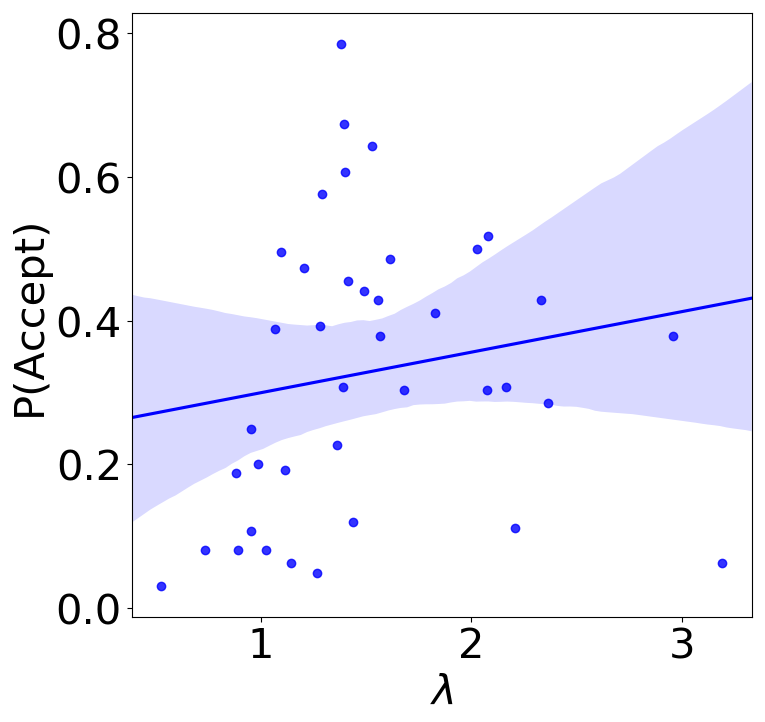

In [84]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue')
plt.xlabel("$\lambda$")
plt.ylabel("P(Accept)")

print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))

('Pearson correlation between gamma and P(Acceptance) is: ', (0.8091334500991824, 4.5487933472388744e-10))


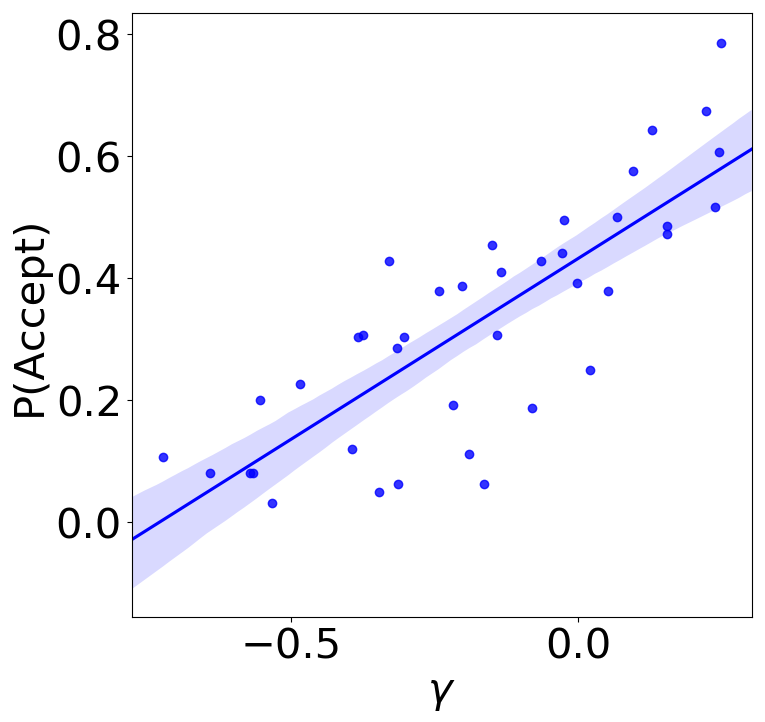

In [85]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue')
plt.xlabel("$\gamma$")
plt.ylabel("P(Accept)")
print("Pearson correlation between gamma and P(Acceptance) is: ", pearsonr(allParticipantsZ, allParticipants_p_accept))

('Pearson correlation between alpha and P(Acceptance) is: ', (0.8921674004614987, 2.461927933524726e-14))


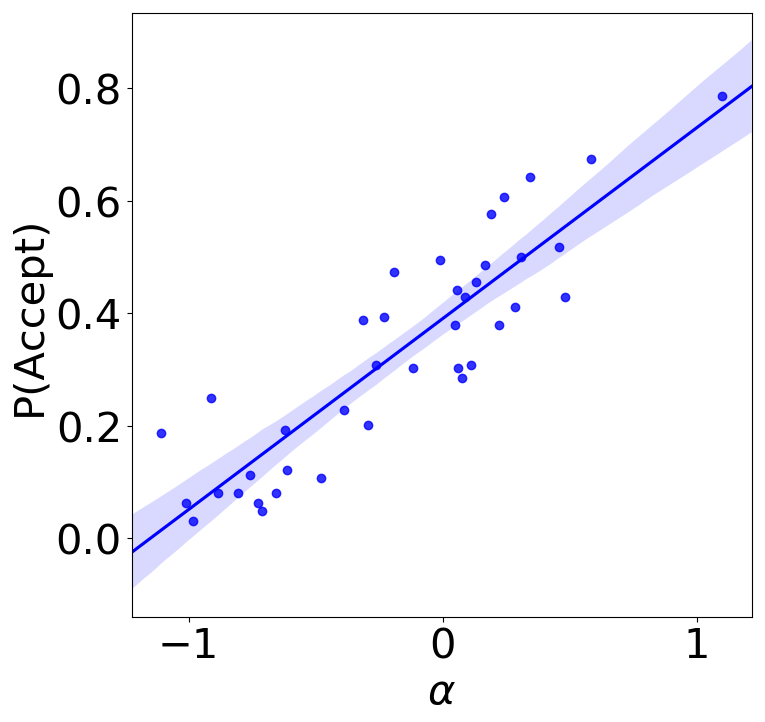

In [86]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel("P(Accept)")
print("Pearson correlation between alpha and P(Acceptance) is: ", pearsonr(allParticipantsAlphas, allParticipants_p_accept))

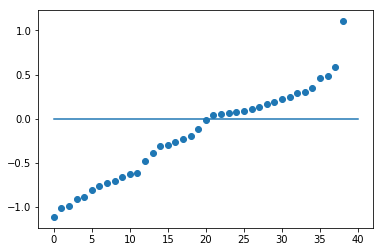

In [55]:
allParticipantAlphasSorted = np.sort(allParticipantsAlphas)
plt.scatter(range(39), allParticipantAlphasSorted)
plt.plot((0, 40), (0, 0))
plt.show()

In [57]:
from scipy import stats

print(stats.ttest_1samp(allParticipantsAlphas, 0))

Ttest_1sampResult(statistic=-2.1981905578127483, pvalue=0.03409852862711755)


# Correlation with lambda (traditional method -- computed using logistic regression)

In [16]:
from sklearn.linear_model import LogisticRegression
indicesToAnalyze = []

for participantIndex in range(numSubjects):
    if allParticipants_p_accept[participantIndex] != 0:
        indicesToAnalyze.append(participantIndex)

def computeParticipantLambdaLR(subjectIndex):
    participantData = zeroSureData[zeroSureData['subj_idx'] == subjectIndex+1]
    X = participantData[['gain', 'loss']]
    y = participantData['response']
    classifier = LogisticRegression().fit(X, y)
    coefficients = classifier.coef_
    participantLambdaLR = coefficients[0][1]/coefficients[0][0]
    return participantLambdaLR

allParticipantLambdasLR = [computeParticipantLambdaLR(_) for _ in indicesToAnalyze]

/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.7093442512665389, 4.3003161273344373e-07))


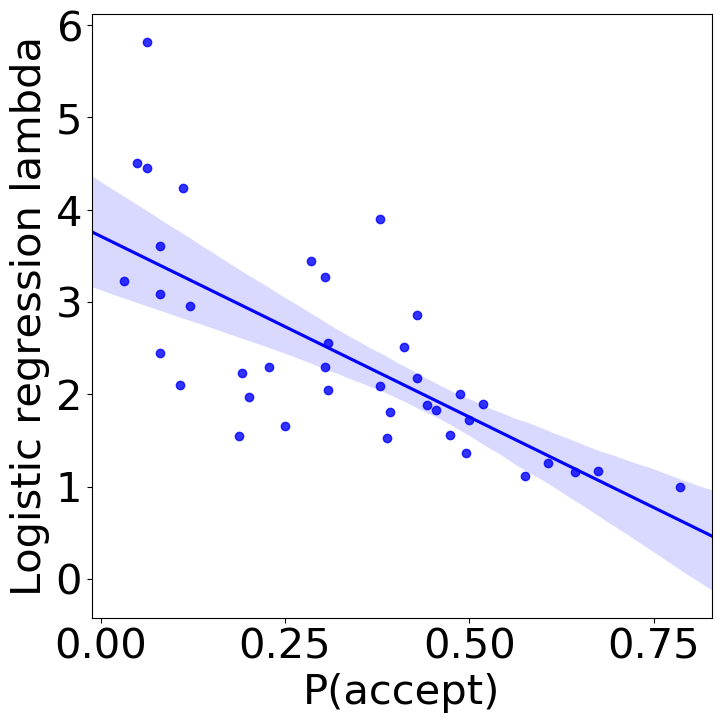

In [20]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
pAcceptToCorrelate = np.array(allParticipants_p_accept)[indicesToAnalyze]
sns.regplot(pAcceptToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel("P(accept)")
plt.ylabel("Logistic regression lambda")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(pAcceptToCorrelate, allParticipantLambdasLR))

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (0.44579425937684924, 0.004451609897691457))


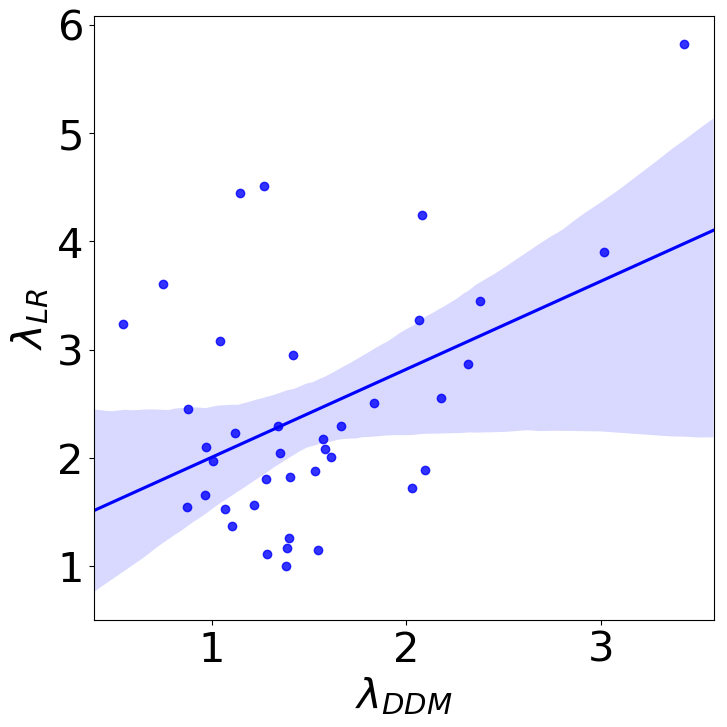

In [21]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
lambdasToCorrelate = np.array(allParticipantLambdas)[indicesToAnalyze]
sns.regplot(lambdasToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\lambda_{DDM}$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(lambdasToCorrelate, allParticipantLambdasLR))

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.4828089909322024, 0.001851613141909984))


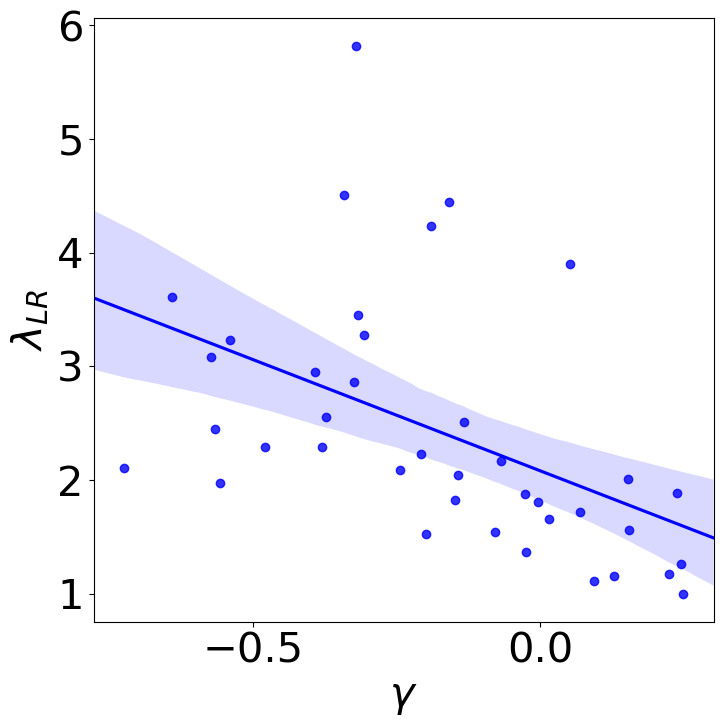

In [22]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
gammasToCorrelate = np.array(allParticipantsZ)[indicesToAnalyze]
sns.regplot(gammasToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(gammasToCorrelate, allParticipantLambdasLR))

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.47203725585208844, 0.0024141978440325655))


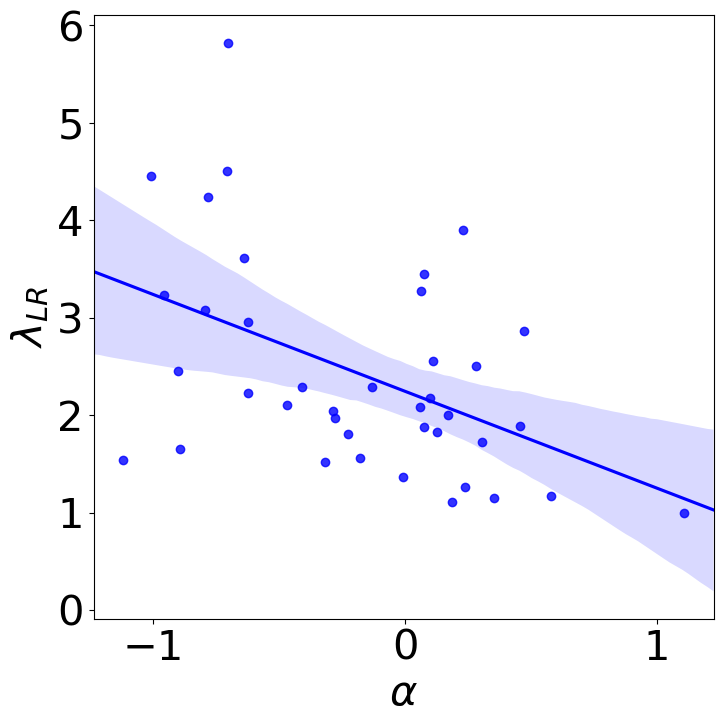

In [23]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
alphasToCorrelate = np.array(allParticipantsAlphas)[indicesToAnalyze]
sns.regplot(alphasToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(alphasToCorrelate, allParticipantLambdasLR))